In [2]:
import numpy as np
import seaborn as sns
import pandas as pd

In [3]:
# EMG Data Shape Info: Shape info: (10319,41)
""" The EMG Data was measured at 2048 Hz, therefore with an estimated video length of 5 seconds, we would see roughly 10240 samples.
    Therefore, we can safely assume that the data presented is the EMG Signals collected from 40 channels every 0.00048828125 seconds and an additional channel
    pull high only at the start of each utterance
"""
emg_data = np.load('Spk1_Block1-Initial_0001_emg.npy')

# Audio Data Shape info: (80640,2)
""" The audio was sampled at 16000 Hz, given that the data is estimated to be around 5 seconds, 
    this would explain how we got a data shape of 80640 x 2. 80640 samples, 1 channel for the audio and another 
    containing a marker that is pulled high by the EMG amplifier at the start of each utterance, allowing for easy
    synchronization of the EMG and audio signals by alignment of
    the markers
"""
audio_data = np.load('Spk1_Block1-Initial_0001_audio.npy')

<Axes: xlabel='Time (1/16000 s)', ylabel='Signal Strength (mV)'>

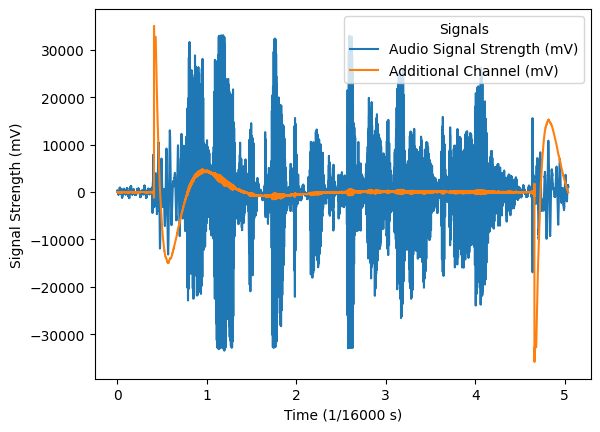

In [13]:
audio_timeInterval = 6.25E-5 # Calculated from 1/sampling rate 
audio_timeSteps = np.arange(0, (len(audio_data)) * audio_timeInterval, audio_timeInterval) # Should equate to 80640
df_audio = pd.DataFrame({'Time (1/16000 s)': audio_timeSteps, 
                         'Audio Signal Strength (mV)': audio_data[:, 0], 
                         'Additional Channel (mV)': audio_data[:, 1]
                        })

df_melted = df_audio.melt(id_vars='Time (1/16000 s)', 
                          value_vars=['Audio Signal Strength (mV)', 'Additional Channel (mV)'], 
                          var_name='Signals', 
                          value_name='Signal Strength (mV)')

sns.lineplot(data=df_melted, x='Time (1/16000 s)', y='Signal Strength (mV)', hue="Signals")


10319


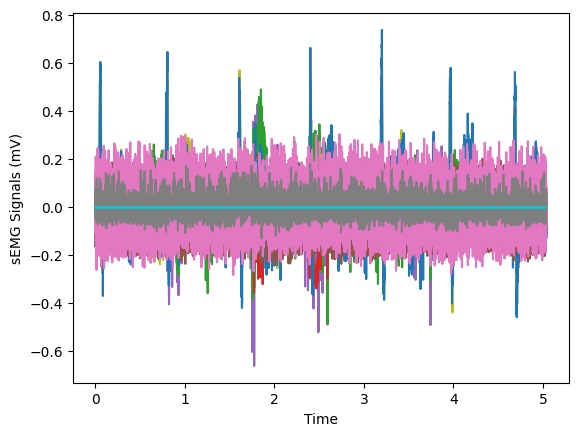

In [19]:
emg_timeInterval = 0.00048828125
emg_timeSteps = np.arange(0, (len(emg_data) * emg_timeInterval), emg_timeInterval)
print(len(emg_timeSteps))

# 40 channels, we're ignoring the last one here
for i in range(40):
  df_emg = pd.DataFrame({'Time': emg_timeSteps,
                         'sEMG Signals (mV)': emg_data[:, i]
                       })
  sns.lineplot(data=df_emg, x='Time', y='sEMG Signals (mV)')



10319


<Axes: xlabel='Time', ylabel='sEMG Signals (mV)'>

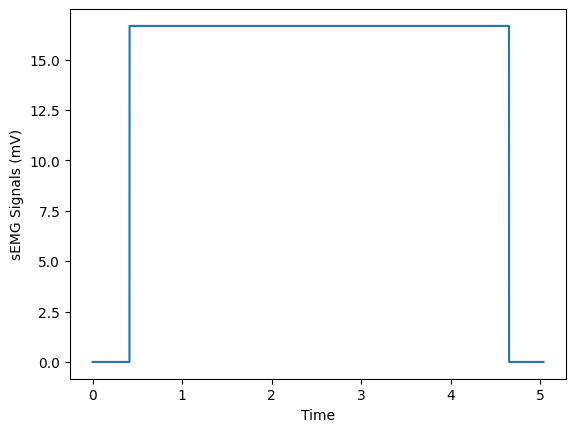

In [21]:
# 1 More to represent data of the 41st Channel (Just used to signify when speaking starts)

emg_timeInterval = 0.00048828125
emg_timeSteps = np.arange(0, (len(emg_data) * emg_timeInterval), emg_timeInterval)
print(len(emg_timeSteps))


df_emgLast = pd.DataFrame({'Time': emg_timeSteps,
                        'sEMG Signals (mV)': emg_data[:, 40]
                      })
sns.lineplot(data=df_emgLast, x='Time', y='sEMG Signals (mV)')